<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/d2l-ai/d2l-pytorch-sagemaker-studio-lab/blob/main/chapter_attention-mechanisms/transformer.ipynb)

# 10.7 Transformer

We have compared CNNs, RNNs, and self-attention in [Self-Attention and Positional Encoding - Section 10.6.2](https://colab.research.google.com/drive/1TKbaAPxr2ZPWF_cFnM-7p0vkZmmuph3z?usp=drive_link)

Notably,
self-attention
enjoys both parallel computation and
the shortest maximum path length.
Therefore natually,
it is appealing to design deep architectures
by using self-attention.
Unlike earlier self-attention models
that still rely on RNNs for input representations [Cheng et al., 2016 - Long short-term memory-networks for machine reading](https://arxiv.org/abs/1601.06733),  [Lin et al., 2017a - A Structured Self-attentive Sentence Embedding](https://arxiv.org/abs/1703.03130) the transformer model is solely based on attention mechanisms without any convolutional or recurrent layer [Vaswani et al., 2017 - Attention Is All You Need](https://arxiv.org/abs/1706.03762).

Though originally proposed
for sequence to sequence learning on text data,
transformers have been pervasive in a wide range of
modern deep learning applications, such as in areas of language, vision, speech, and reinforcement learning.

[References](1JUH94YF03fSYrlGBTDUQb76MU-bFWIqW)

## 10.7.1 Model


As an instance of the encoder-decoder
architecture,
the overall architecture of
the transformer
is presented in [Fig. 10.7.1](#fig10.7.1).
As we can see,
the transformer is composed of an encoder and a decoder.
Different from
Bahdanau attention
for sequence to sequence learning
in [Bahdanau-attention](1z4kHtZMwVobaVMJnHBNbcsHB0RGVvh-8), [Fig. 10.4.1](https://drive.google.com/file/d/1SIA-3alLgbfehK_AfT3L0EOgPy3r9jzE/view?usp=drive_link)

the input (source) and output (target)
sequence embeddings
are added with positional encoding
before being fed into
the encoder and the decoder
that stack modules based on self-attention.

[The transformer architecture.](https://drive.google.com/file/d/1Mww3_o7I4Bs61lF16Oqk145XKvz06YJY/view?usp=sharing)

![The transformer architecture.](https://drive.google.com/uc?id=1Mww3_o7I4Bs61lF16Oqk145XKvz06YJY)


<center id="fig10.7.1"><i>Fig. 10.7.1 The transformer architecture.</i></center>

Now we provide an overview of the
transformer architecture in [Fig. 10.7.1](#fig10.7.1).
On a high level,
the transformer encoder is a stack of multiple identical layers,
where each layer
has two sublayers (either is denoted as $\mathrm{sublayer}$).
The first
is a multi-head self-attention pooling
and the second is a positionwise feed-forward network.
Specifically,
in the encoder self-attention,
queries, keys, and values are all from the
the outputs of the previous encoder layer.
Inspired by the ResNet design in
[Section 7.6 - Residual Networks (ResNet) and ResNeXt](https://colab.research.google.com/drive/10_tP6pLTQ4LoMenlCYaFLljkH732Lnpd?usp=drive_link)

a residual connection is employed
around both sublayers.
In the transformer,
for any input $\mathbf{x} \in \mathbb{R}^d$ at any position of the sequence,
we require that $\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ so that
the residual connection $\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ is feasible.
This addition from the residual connection is immediately
followed by layer normalization [Ba et al., 2016 - Layer Normalization - paper](https://arxiv.org/abs/1607.06450).
As a result, the transformer encoder outputs a $d$-dimensional vector representation for each position of the input sequence.

The transformer decoder is also
a stack of multiple identical layers with residual connections and layer normalizations.
Besides the two sublayers described in
the encoder, the decoder inserts
a third sublayer, known as
the encoder-decoder attention,
between these two.
In the encoder-decoder attention,
queries are from the
outputs of the previous decoder layer,
and the keys and values are
from the transformer encoder outputs.
In the decoder self-attention,
queries, keys, and values are all from the
the outputs of the previous decoder layer.
However,
each position in the decoder is
allowed to only attend to all positions in the decoder
up to that position.
This *masked* attention
preserves the auto-regressive property,
ensuring that the prediction only depends on those output tokens that have been generated.

We have already described and implemented
multi-head attention based on scaled dot-products
in [Section 10.5 - Multi-Head Attention](https://colab.research.google.com/drive/1AtbDXayEIjzMFZK9Bgg_MnlxtxkYr2z6?usp=drive_link)

In the following,
we will implement the rest of the transformer model.

[References](1JUH94YF03fSYrlGBTDUQb76MU-bFWIqW)


In [ ]:
# https://www.google.com/search?q=embedding+your+image+in+google+colab+markdown&oq=&aqs=chrome.0.35i39i362l8.1372j0j15&sourceid=chrome&ie=UTF-8

!pip install d2l

import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.2
    Uninstalling scipy-1.11.2:
      Successfully uninstalled scipy-1.11.2
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
     

## 10.7.2 Positionwise Feed-Forward Networks

The positionwise feed-forward network
transforms
the representation at all the sequence positions
using the same MLP.
This is why we call it *positionwise*.
In the implementation below,
the input `X` with shape
(batch size, number of time steps or sequence length in tokens, number of hidden units or feature dimension)
will be transformed by a two-layer MLP into
an output tensor of shape
(batch size, number of time steps, `ffn_num_outputs`).


In [ ]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

The following example
shows that the innermost dimension
of a tensor changes to
the number of outputs in
the positionwise feed-forward network.
Since the same MLP transforms
at all the positions,
when the inputs at all these positions are the same,
their outputs are also identical.


In [ ]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.6498, -0.3560,  0.0161, -0.7885,  0.1493,  0.2143,  1.1569,  1.2727],
        [ 0.6498, -0.3560,  0.0161, -0.7885,  0.1493,  0.2143,  1.1569,  1.2727],
        [ 0.6498, -0.3560,  0.0161, -0.7885,  0.1493,  0.2143,  1.1569,  1.2727]],
       grad_fn=<SelectBackward0>)

## 10.7.3 Residual Connection and Layer Normalization

Now let us focus on
the "add & norm" component in [Fig. 10.7.1](#fig10.7.1).
As we described at the beginning
of this section,
this is a residual connection immediately
followed by layer normalization.
Both are key to effective deep architectures.

In [Section 7.5](../chapter_convolutional-modern/batch-norm.ipynb),
we explained how batch normalization
recenters and rescales across the examples within
a minibatch.
Layer normalization is the same as batch normalization
except that the former
normalizes across the feature dimension.
Despite its pervasive applications
in computer vision,
batch normalization
is usually empirically
less effective than layer normalization
in natural language processing
tasks, whose inputs are often
variable-length sequences.

The following code snippet
compares the normalization across different dimensions
by layer normalization and batch normalization.


In [ ]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


Now we can implement the `AddNorm` class
using a residual connection followed by layer normalization.
Dropout is also applied for regularization.


In [ ]:

class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

The residual connection requires that
the two inputs are of the same shape
so that the output tensor also has the same shape after the addition operation.


In [ ]:
add_norm = AddNorm([3, 4], 0.5)  # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 10.7.4 Encoder

With all the essential components to assemble
the transformer encoder,
let us start by
implementing a single layer within the encoder.
The following `EncoderBlock` class
contains two sublayers: multi-head self-attention and positionwise feed-forward networks,
where a residual connection followed by layer normalization is employed
around both sublayers.


In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(valid_lens,
                                                 repeats=self.num_heads,
                                                 dim=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)



class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        #self.attention = d2l.MultiHeadAttention(key_size, query_size,
        #                                        value_size, num_hiddens,
        #                                        num_heads, dropout, use_bias)

        self.attention = MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))




As we can see,
any layer in the transformer encoder
does not change the shape of its input.


In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
#encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24])
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In the following transformer encoder implementation,
we stack `num_layers` instances of the above `EncoderBlock` classes.
Since we use the fixed positional encoding
whose values are always between -1 and 1,
we multiply values of the learnable input embeddings
by the square root of the embedding dimension
to rescale before summing up the input embedding and the positional encoding.


In [ ]:

class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

Below we specify hyperparameters to create a two-layer transformer encoder.
The shape of the transformer encoder output
is (batch size, number of time steps, `num_hiddens`).


In [ ]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 10.7.5 Decoder

As shown in [Fig. 10.7.1](#fig10.7.1),
the transformer decoder
is composed of multiple identical layers.
Each layer is implemented in the following
`DecoderBlock` class,
which contains three sublayers:
decoder self-attention,
encoder-decoder attention,
and positionwise feed-forward networks.
These sublayers employ
a residual connection around them
followed by layer normalization.


As we described earlier in this section,
in the masked multi-head decoder self-attention
(the first sublayer),
queries, keys, and values
all come from the outputs of the previous decoder layer.
When training sequence-to-sequence models,
tokens at all the positions (time steps)
of the output sequence
are known.
However,
during prediction
the output sequence is generated token by token;
thus,
at any decoder time step
only the generated tokens
can be used in the decoder self-attention.
To preserve auto-regression in the decoder,
its masked self-attention
specifies  `dec_valid_lens` so that
any query
only attends to
all positions in the decoder
up to the query position.


In [ ]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

To facilitate scaled dot-product operations
in the encoder-decoder attention
and addition operations in the residual connections,
the feature dimension (`num_hiddens`) of the decoder is
the same as that of the encoder.


In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Now we construct the entire transformer decoder
composed of `num_layers` instances of `DecoderBlock`.
In the end,
a fully-connected layer computes the prediction
for all the `vocab_size` possible output tokens.
Both of the decoder self-attention weights
and the encoder-decoder attention weights
are stored for later visualization.


In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 10.7.6 Training

Let us instantiate an encoder-decoder model
by following the transformer architecture.
Here we specify that
both the transformer encoder and the transformer decoder
have 2 layers using 4-head attention.
Similar to [Section 9.7.4](../chapter_recurrent-modern/seq2seq.ipynb#9.7.4-Training),
we train the transformer model
for sequence to sequence learning on the English-French machine translation dataset.


loss 0.032, 5876.0 tokens/sec on cuda:0


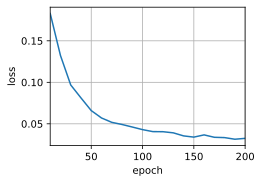

In [ ]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)

class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

        return self.decoder(dec_X, dec_state)

def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

net = EncoderDecoder(encoder, decoder)

#train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)


After training,
we use the transformer model
to translate a few English sentences into French and compute their BLEU scores.


In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


Let us visualize the transformer attention weights when translating the last English sentence into French.
The shape of the encoder self-attention weights
is (number of encoder layers, number of attention heads, `num_steps` or number of queries, `num_steps` or number of key-value pairs).


In [ ]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

In the encoder self-attention,
both queries and keys come from the same input sequence.
Since padding tokens do not carry meaning,
with specified valid length of the input sequence,
no query attends to positions of padding tokens.
In the following,
two layers of multi-head attention weights
are presented row by row.
Each head independently attends
based on a separate representation subspaces of queries, keys, and values.


In [ ]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

# https://drive.google.com/file/d/1wlO51ZXX2gO7lu8uRu8Z3bjTeivX7ncu/view?usp=drive_link

To visualize both the decoder self-attention weights and the encoder-decoder attention weights,
we need more data manipulations.
For example,
we fill the masked attention weights with zero.
Note that
the decoder self-attention weights
and the encoder-decoder attention weights
both have the same queries:
the beginning-of-sequence token followed by
the output tokens.


In [ ]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

Due to the auto-regressive property of the decoder self-attention,
no query attends to key-value pairs after the query position.


In [ ]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

# https://drive.google.com/file/d/1Lj0g4KD9oPjyp76MO7_NeHprZimk8Vg7/view?usp=drive_link


Similar to the case in the encoder self-attention,
via the specified valid length of the input sequence,
no query from the output sequence
attends to those padding tokens from the input sequence.


In [ ]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

# https://drive.google.com/file/d/1OHhmcs8M7aTmXm4-klVigRweVhcMJRJu/view?usp=drive_link

Although the transformer architecture
was originally proposed for sequence-to-sequence learning,
as we will discover later in the book,
either the transformer encoder
or the transformer decoder
is often individually used
for different deep learning tasks.


## 10.7.7 Summary

* The transformer is an instance of the encoder-decoder architecture, though either the encoder or the decoder can be used individually in practice.
* In the transformer, multi-head self-attention is used for representing the input sequence and the output sequence, though the decoder has to preserve the auto-regressive property via a masked version.
* Both the residual connections and the layer normalization in the transformer are important for training a very deep model.
* The positionwise feed-forward network in the transformer model transforms the representation at all the sequence positions using the same MLP.


## 10.7.8 Exercises

1. Train a deeper transformer in the experiments. How does it affect the training speed and the translation performance?
1. Is it a good idea to replace scaled dot-product attention with additive attention in the transformer? Why?
1. For language modeling, should we use the transformer encoder, decoder, or both? How to design this method?
1. What can be challenges to transformers if input sequences are very long? Why?
1. How to improve computational and memory efficiency of transformers? Hint: you may refer to the survey paper by Tay et al. [Tay et al., 2020](../chapter_references/zreferences.ipynb#Tay.Dehghani.Bahri.ea.2020).
1. How can we design transformer-based models for image classification tasks without using CNNs? Hint: you may refer to the vision transformer [Dosovitskiy et al., 2021](../chapter_references/zreferences.ipynb#Dosovitskiy.Beyer.Kolesnikov.ea.2021).
